# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import HistoricalData
from pymongo import MongoClient

#Read historical data from API and save it at Mongo DB

We call getHistoricalPrices method at HistoricalData.py file witch read crypto curancy data from API and save it at Mongo DB

In [109]:
btc_prices = HistoricalData.getHistoricalPrices("BTC", "hours",100)
print('id:',btc_prices)

{'insertion_datetime': '2024-04-13 06:07:59', 'coin': 'BTC', 'period_count': 100, 'period_unit': 'hours', 'prices_data': [{'time': '2024-04-09 02:00:00', 'high': 71320.99, 'low': 70957.78, 'open': 71197.09, 'volumefrom': 720.53, 'volumeto': 51241939.5, 'close': 71047.56, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 03:00:00', 'high': 71282.25, 'low': 70604.79, 'open': 71047.56, 'volumefrom': 1224.87, 'volumeto': 86840779.27, 'close': 70780.29, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 04:00:00', 'high': 70944.25, 'low': 70214.93, 'open': 70780.29, 'volumefrom': 1363.97, 'volumeto': 96231178.76, 'close': 70402.51, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 05:00:00', 'high': 70609.77, 'low': 69643.47, 'open': 70402.51, 'volumefrom': 2430.07, 'volumeto': 170337031.02, 'close': 70527.26, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 06:00:00', 'high': 70850.02, 'low': 70

# Read Data from Mongo DB

We connect to Mongo DB and historicalPrices Collection
than fine the document that we have saved it recently base on the id that we have (returned by the method getHistoricalPrices)

In [110]:
client = MongoClient('mongodb://localhost:27017/')
db = client['INF7225']
collection = db['historicalPrices']
cursor = collection.find({'_id':btc_prices})
for data in cursor:
    df = pd.DataFrame(data['prices_data'])
    print(data)
    
client.close()
print(df)

{'_id': ObjectId('661a4b6f471a71786d27a0ba'), 'insertion_datetime': '2024-04-13 06:07:59', 'coin': 'BTC', 'period_count': 100, 'period_unit': 'hours', 'prices_data': [{'time': '2024-04-09 02:00:00', 'high': 71320.99, 'low': 70957.78, 'open': 71197.09, 'volumefrom': 720.53, 'volumeto': 51241939.5, 'close': 71047.56, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 03:00:00', 'high': 71282.25, 'low': 70604.79, 'open': 71047.56, 'volumefrom': 1224.87, 'volumeto': 86840779.27, 'close': 70780.29, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 04:00:00', 'high': 70944.25, 'low': 70214.93, 'open': 70780.29, 'volumefrom': 1363.97, 'volumeto': 96231178.76, 'close': 70402.51, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024-04-09 05:00:00', 'high': 70609.77, 'low': 69643.47, 'open': 70402.51, 'volumefrom': 2430.07, 'volumeto': 170337031.02, 'close': 70527.26, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': '2024

# verify data

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              101 non-null    object 
 1   high              101 non-null    float64
 2   low               101 non-null    float64
 3   open              101 non-null    float64
 4   volumefrom        101 non-null    float64
 5   volumeto          101 non-null    float64
 6   close             101 non-null    float64
 7   conversionType    101 non-null    object 
 8   conversionSymbol  101 non-null    object 
dtypes: float64(6), object(3)
memory usage: 7.2+ KB


make sure index type is int

In [112]:
df.index = df.index.astype(int)

# Data Cleaning

For null data we decide to replace it with next record of data because With this method, we maintain the increasing or decreasing trend of the flow

In [113]:
# Fill null values with next record value
df.fillna(method='ffill', inplace=True)

# Drop rows with null values at the end
df.dropna(axis=0, how='any', inplace=True)

Delete duplicated records

In [114]:
df.drop_duplicates(inplace=True)

make sure Data Types are currect:

In [115]:

df['open'] = df['open'].astype(float) 
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volumefrom'] = df['volumefrom'].astype(float)
df['volumeto'] = df['volumeto'].astype(float)
df['conversionType'] = df['conversionType'].astype(str)
df['conversionSymbol'] = df['conversionSymbol'].astype(str)



detectiong outline fieldes
we use Zscore method to recugenise outline values 
at this method we calculate Zscore value of each field and if they are bigger than +3 or smaller than -3 we replace the field value with previos record

In [116]:
df['Open_Zscore'] = stats.zscore(df['open'])
df['High_Zscore'] = stats.zscore(df['high'])
df['Low_Zscore'] = stats.zscore(df['low'])
df['Volumefr_Zscore'] = stats.zscore(df['volumefrom'])
df['Volumeto_Zscore'] = stats.zscore(df['volumeto'])


threshold = 3

outliers_open = df[df['Open_Zscore'].abs() > threshold]
outliers_high = df[df['High_Zscore'].abs() > threshold]
outliers_low = df[df['Low_Zscore'].abs() > threshold]
outliers_volumefr = df[df['Volumefr_Zscore'].abs() > threshold]
outliers_volumeto = df[df['Volumeto_Zscore'].abs() > threshold]



Replace the outline fields with the value of previous record

In [117]:
for idx in outliers_open.index:
    df.at[idx, 'open'] = df.at[idx-1, 'open']

for idx in outliers_high.index:
    df.at[idx, 'high'] = df.at[idx-1, 'high']

for idx in outliers_low.index:
    df.at[idx, 'low'] = df.at[idx-1, 'low']

for idx in outliers_volumefr.index:
    df.at[idx, 'volumefrom'] = df.at[idx-1, 'volumefrom']

for idx in outliers_volumeto.index:
    df.at[idx, 'volumeto'] = df.at[idx-1, 'volumeto']

# Drop Z-score columns
df.drop(['Open_Zscore', 'High_Zscore', 'Low_Zscore', 'Volumefr_Zscore', 'Volumeto_Zscore'], axis=1, inplace=True)

print(df)

                    time      high       low      open  volumefrom  \
0    2024-04-09 02:00:00  71320.99  70957.78  71197.09      720.53   
1    2024-04-09 03:00:00  71282.25  70604.79  71047.56     1224.87   
2    2024-04-09 04:00:00  70944.25  70214.93  70780.29     1363.97   
3    2024-04-09 05:00:00  70609.77  69643.47  70402.51     2430.07   
4    2024-04-09 06:00:00  70850.02  70283.83  70527.26     1043.96   
..                   ...       ...       ...       ...         ...   
96   2024-04-13 02:00:00  68422.60  67333.23  67597.13     1492.85   
97   2024-04-13 03:00:00  67523.87  67284.80  67358.64      697.81   
98   2024-04-13 04:00:00  67579.87  67149.01  67491.61      955.40   
99   2024-04-13 05:00:00  67471.96  67115.96  67459.68      712.20   
100  2024-04-13 06:00:00  67499.95  67164.74  67190.85      467.82   

         volumeto     close conversionType conversionSymbol  
0    5.124194e+07  71047.56         direct                   
1    8.684078e+07  70780.29        

Plotting the data

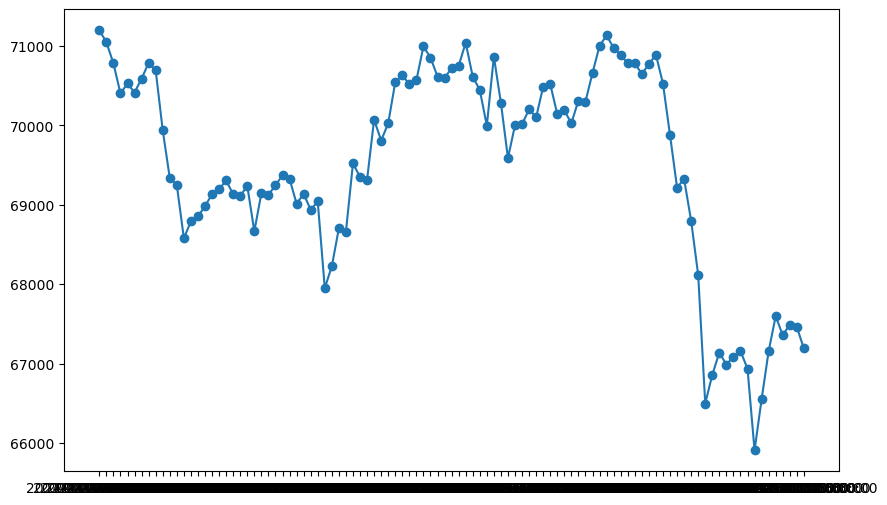

In [118]:

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['open'], marker='o', linestyle='-')

# Feature Engineering

For analyzing crypto curencies we will use Ichimoko Algoritm and for deploying ichimoko we should add som features to our Data Frame

calculate and add Tenkan_sen

In [119]:
df['Highest'] = df['high'].rolling(window=9).max()
df['Lowest'] = df['low'].rolling(window=9).min()

df['Tenkan_sen'] = (df['Highest'] + df['Lowest']) / 2

df.drop(columns=['Highest'], inplace=True)
df.drop(columns=['Lowest'], inplace=True)

calculate and add Kijun_sen

In [120]:
df['Highest'] = df['high'].rolling(window=26).max()
df['Lowest'] = df['low'].rolling(window=26).min()


df['Kijun_sen'] = (df['Highest'] + df['Lowest']) / 2
df.drop(columns=['Highest'], inplace=True)
df.drop(columns=['Lowest'], inplace=True)


calculate and add Chikou_span

In [121]:
df['Chikou_span'] = df['close'].shift(26)

In [122]:
df.head(50)

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,Tenkan_sen,Kijun_sen,Chikou_span
0,2024-04-09 02:00:00,71320.99,70957.78,71197.09,720.53,5.124194e+07,71047.56,direct,,NaN,NaN,NaN
1,2024-04-09 03:00:00,71282.25,70604.79,71047.56,1224.87,8.684078e+07,70780.29,direct,,NaN,NaN,NaN
2,2024-04-09 04:00:00,70944.25,70214.93,70780.29,1363.97,9.623118e+07,70402.51,direct,,NaN,NaN,NaN
3,2024-04-09 05:00:00,70609.77,69643.47,70402.51,2430.07,1.703370e+08,70527.26,direct,,NaN,NaN,NaN
4,2024-04-09 06:00:00,70850.02,70283.83,70527.26,1043.96,7.366709e+07,70413.57,direct,,NaN,NaN,NaN
5,2024-04-09 07:00:00,70681.27,70250.02,70413.57,701.32,4.942579e+07,70587.46,direct,,NaN,NaN,NaN
6,2024-04-09 08:00:00,70903.21,70580.37,70587.46,1014.04,7.176762e+07,70787.43,direct,,NaN,NaN,NaN
7,2024-04-09 09:00:00,70958.62,70653.53,70787.43,767.40,5.433066e+07,70690.98,direct,,NaN,NaN,NaN
8,2024-04-09 10:00:00,70932.45,69932.44,70690.98,1890.03,1.332313e+08,69937.72,direct,,70482.230,NaN,NaN
9,2024-04-09 11:00:00,70428.61,68636.53,69937.72,4511.99,3.134012e+08,69337.43,direct,,69959.390,NaN,NaN


# Plottin the Ichimoko plot

Ploting to view the important features

In [123]:
graph_period = 20

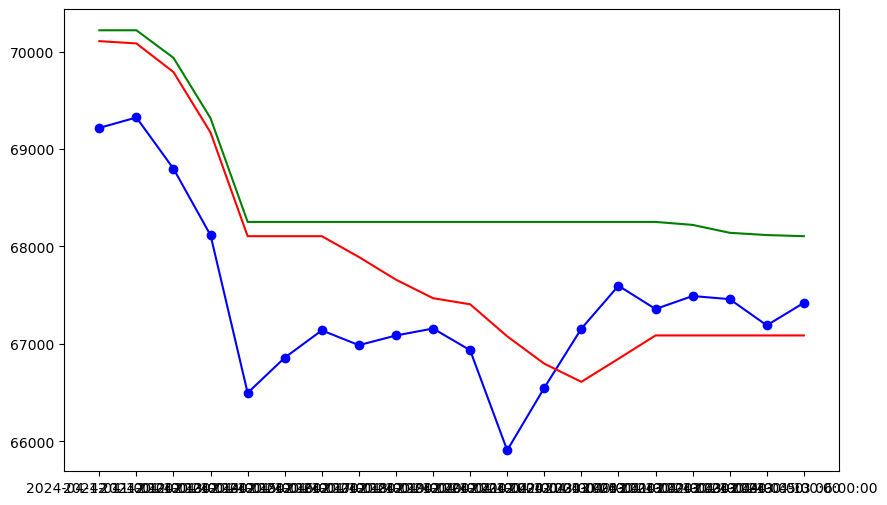

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(df['time'].iloc[-graph_period:], df['close'].iloc[-graph_period:], marker='o', linestyle='-',color='blue')
plt.plot(df['time'].iloc[-graph_period:], df['Tenkan_sen'].iloc[-graph_period:], linestyle='-',color='red' )
plt.plot(df['time'].iloc[-graph_period:], df['Kijun_sen'].iloc[-graph_period:], linestyle='-',color='green' )




from this plot we can undrestand what will happen at the next timestamp:

If the price chart (Blue) crosses the Tenkan_sen chart  (Red) upwards, we will probably have a price increase in the short term and we suggest buying.

If the price chart (Blue) crosses the Tenkan_sen chart (Red) downwards, we will probably have a short-term price decrease and suggest selling.

If the price chart (Blue) crosses the Kijun_sen chart (Green) upwards, we will probably have a price increase in the long term and we suggest buying.

If the price chart (Blue) crosses the Kijun_sen chart (Green) downwards, we will probably have a long-term price decrease and suggest selling.

# Deploying Algoritm

If the price chart (Blue) crosses the Tenkan_sen chart (Red) upwards, and stay for one timestamp we will probably have a price increase in the short term and we suggest buying signal.

If the price chart (Blue) crosses the Tenkan_sen chart (Red) downwards, and stay for one timestamp we will probably have a price decrease in the short term and we suggest selling signal.

In [125]:
df['Tenkan_up_price'] = df['close']>=df['Tenkan_sen']

df['Tenkan_breaked_up'] =  (df['Tenkan_up_price'] != df['Tenkan_up_price'].shift(1)) & ( df['Tenkan_up_price'])
df['buy_Tenkan_signal'] = df['Tenkan_breaked_up'].shift(1) & (df['Tenkan_up_price'] == df['Tenkan_up_price'].shift(1))

df['Tenkan_breaked_down'] =  (df['Tenkan_up_price'] != df['Tenkan_up_price'].shift(1)) & (~df['Tenkan_up_price'])
df['sell_Tenkan_signal'] = (df['Tenkan_breaked_down'].shift(1)) & (df['Tenkan_up_price'] == df['Tenkan_up_price'].shift(1))

If the price chart (Blue) crosses the Kijun_sen chart (Green) upwards, and stay for one timestamp we will probably have a price increase in the long term and we suggest buying signal.

If the price chart (Blue) crosses the Kijun_sen chart (Red) downwards, and stay for one timestamp we will probably have a price decrease in the long term and we suggest selling signal.

In [126]:
df['Kijun_up_price'] = df['close']>=df['Kijun_sen']

df['Kijun_breaked_up'] =  (df['Kijun_up_price'] != df['Kijun_up_price'].shift(1)) & ( df['Kijun_up_price'])
df['buy_Kijun_signal'] = df['Kijun_breaked_up'].shift(1) & (df['Kijun_up_price'] == df['Kijun_up_price'].shift(1))

df['Kijun_breaked_down'] =  (df['Kijun_up_price'] != df['Kijun_up_price'].shift(1)) & (~df['Kijun_up_price'])
df['sell_Kijun_signal'] = (df['Kijun_breaked_down'].shift(1)) & (df['Kijun_up_price'] == df['Kijun_up_price'].shift(1))

In [127]:
df[-20:]

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,Tenkan_sen,...,Tenkan_up_price,Tenkan_breaked_up,buy_Tenkan_signal,Tenkan_breaked_down,sell_Tenkan_signal,Kijun_up_price,Kijun_breaked_up,buy_Kijun_signal,Kijun_breaked_down,sell_Kijun_signal
81,2024-04-12 11:00:00,70061.60,69190.57,69878.66,2977.68,2.071619e+08,69217.05,direct,,70107.045,...,False,False,False,False,False,False,False,False,False,True
82,2024-04-12 12:00:00,69681.52,69199.02,69217.05,1755.03,1.218376e+08,69323.90,direct,,70083.825,...,False,False,False,False,False,False,False,False,False,False
83,2024-04-12 13:00:00,69556.60,68625.40,69323.90,3214.41,2.215038e+08,68798.12,direct,,69789.675,...,False,False,False,False,False,False,False,False,False,False
84,2024-04-12 14:00:00,68898.54,67384.14,68798.12,3214.41,2.215038e+08,68115.40,direct,,69169.045,...,False,False,False,False,False,False,False,False,False,False
85,2024-04-12 15:00:00,68337.00,65257.57,68115.40,3214.41,2.215038e+08,66497.62,direct,,68105.760,...,False,False,False,False,False,False,False,False,False,False
86,2024-04-12 16:00:00,67324.96,66337.08,66497.62,4565.08,3.049980e+08,66859.15,direct,,68105.760,...,False,False,False,False,False,False,False,False,False,False
87,2024-04-12 17:00:00,67471.15,66731.76,66859.15,2631.81,1.767740e+08,67139.44,direct,,68105.760,...,False,False,False,False,False,False,False,False,False,False
88,2024-04-12 18:00:00,67141.96,66708.61,67139.44,1544.18,1.032088e+08,66987.62,direct,,67892.250,...,False,False,False,False,False,False,False,False,False,False
89,2024-04-12 19:00:00,67280.71,66860.00,66987.62,1247.03,8.364902e+07,67086.90,direct,,67659.585,...,False,False,False,False,False,False,False,False,False,False
90,2024-04-12 20:00:00,67255.90,66842.30,67086.90,905.57,6.069388e+07,67158.30,direct,,67469.545,...,False,False,False,False,False,False,False,False,False,False


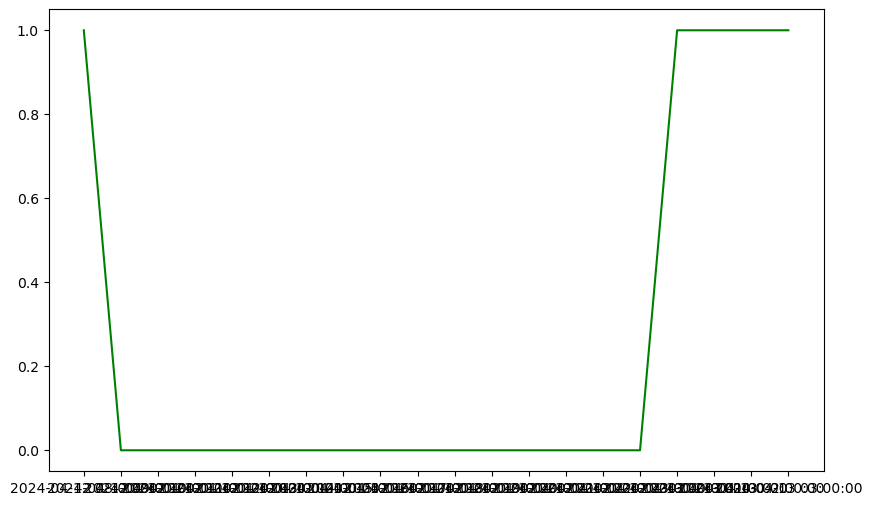

In [29]:
# plt.figure(figsize=(10, 6))
# plt.plot(df['time'].iloc[-graph_period:], df['close'].iloc[-graph_period:], marker='o', linestyle='-',color='blue')
# plt.plot(df['time'].iloc[-graph_period:], df['Tenkan_sen'].iloc[-graph_period:], linestyle='-',color='red' )
# plt.plot(df['time'].iloc[-graph_period:], df['Kijun_sen'].iloc[-graph_period:], linestyle='-',color='green' )
# plt.plot(df['time'].iloc[-graph_period:], df['Tenkan_breaked_Up'].iloc[-graph_period:], linestyle='-',color='green' )


Other onalyz:

If the two Tenkan_sen and Kijun_sen charts are flat, the market trend is neutral

If the price chart is above the two Tenkan_sen and Kijun_sen charts, it is an upward trend

If it is below the two Tenkan_sen and Kijun_sen charts, it is a downward trend